# Introduction to ham1d package

## What is this notebook about?

This Jupyter notebook serves as an introduction to the ham1d package. The package is intended
for construction of 1-dimensional quantum Hamiltonians in either fermionic or hard-core bosonic
(spin 1/2) case. In the following sections we show how to use the package's functionalities in the
form of walk-through examples.

## The intented usage

Construction of 1D lattice hamiltonians for both the fermionic and hard-core bosonic as well as
noninteracting case. The aim of this code is to provide functionality for rather simple and
straightforward implementation of arbitrary (though physically relevant and, importantly, sparse)
1D quantum hamiltonians.

## What is currently implemented?

The package currently implements three classes, which allow for construction of:

* fermionic 1D Hamiltonians (defined in ```ham1d.models.ferm1d```)
* hard-core bosonic 1D Hamiltonians (defined in ```ham1d.models.spin1d```)
* noninteracting 1D case (defined in ```ham1d.models.free1d```)

The above three casese are defined in the usual way, where a Hilbert space basis
is first constructed and then the model Hamiltonian is obtained by Hamiltonian
action on the basis states. To speed up the code just-in-time compilation (jit)
tools from the ```numba``` library are used. Note that while the first two
implementations could also handle the noninteracting case, the underlying array
constructions are specifically tailored for the interacting case and its exponential
scaling of the corresponding Hilbert space dimensions. To reach larger system sizes
in the noninteracting case, one should thus make use of the code for the noninteracting
systems.
Additionaly, Hamiltonian construction
using the Kronecker product of sparse matrices is also supported in the hard-core
bosonic case:

* hard-core bosonic 1D Hamiltonians using sparse Kronecker product (defined in ```ham1d.models.spin1d_kron```)

## TO DO:

* conduct proper testing
* provide documentation using sphinx
* provide functionalities for the time-dependent hamiltonians

## Usage examples

First, load the necessary modules. Currently, the ```ham1d``` package has the following
subpackages:

* ```basis``` (not yet implemented, only a placeholder for now)
* ```models``` (the most relevant for the end user, this is where the typical Hamiltonian classes are defined)
* ```operators``` (where the internal routines are implemented, should not be visible to the end user and could as well be designated as private in the future)

In [2]:
%matplotlib inline
"""
Each of the modules defined in ham1d.models defines a class
for construction of a particular hamiltonian type. All of the
classes share the same base class and thus their functionality
is more or less the same, the difference is in the internal routines
used.
"""

# to load classes utilizing numba's jit
# compilation optimizations, load the following
# modules. The following lines would load modules
# with routines for creation of spin 1/2 (hard-core
# bosonic), spinless fermionic and noninteracting
# hamiltonians.
from ham1d.models import spin1d as sp1
from ham1d.models import ferm1d as fe1
from ham1d.models import free1d as fr1

# in case of the spin 1/2 hamiltonians,
# one can also construct the model hamiltonians
# using the kronecker product of sparse operators.
# In general, this could be easily achieved for
# any spin value, simply by providing an appropriate
# set of spin operators. For now, only the spin 1/2
# matrices are provided.
from ham1d.models import spin1d_kron as spk

import numpy as np
import matplotlib.pyplot as plt

### Construct a spin 1/2 hamiltonian and diagonalize it

Below we will display some of the packages's key functionalities by constructing
an isotropic XXZ spin 1/2 hamiltonian in the presence of quasirandom magnetic field
and then obtaining its eigenvalues and eigenvectors. The interface presented below
also applies to all the other cases defined above. Below is an excerpt from the
packages's documentation:

```python
"""
A hamiltonian class for some typical hamiltonian type <type>
is instantiated as follows:

hamiltonian = <type>(L, static_list, dynamic_list=[], t=0, Nu=None)

Note that the examples below correspond to the spin 1/2 case but the
syntax in all other cases is very much the same.

Parameters
----------

L: int
    An integer specifying the spin chain length.

static_list: list
    A nested list of the operator description strings
    and site-coupling lists for the time-independent
    part of the Hamiltonian. An example of the
    static_ham list would be:

        static_ham = [['zz', J_zz]]

    Here, 'zz' is the operator descriptor string specifiying
    2-spin interaction along the z-axis direction. For a chain-
    of L sites with constant nearest-neighbour exchange
    J and PBC, the site coupling list would be given by:

        J_zz = [[J, i, (i+1)%L] for i in range(L)]

    In the upper expression, J is the term describing
    the interaction strength and the following entries
    in the inner list specify the positions of the coupled
    sites. The upper example should serve as a general
    template which should allow for simple extension to
    the case of n-spin interaction and varying couplings.

dynamic_list: list
    A nested list of the operator description strings. The
    description is similar to the static_ham description,
    however, additional terms are needed to incorporate
    the time dependence: an example would be:

        dynamic_ham = [['zz', J_zz, time_fun, time_fun_args]]

    Here, 'zz' is the same operator descriptor string as the
    one in the static case. J_zz, however, now refers to
    the initial (dynamic) site coupling list at t=0. time_fun
    is a function object describing a protocol for
    time-dependent part of the hamiltonian with the following
    interface: time_fun(t, *time_fun_args) where time_fun_args
    are the possible additional arguments of the time-dependence.
    NOTE THAT THIS FUNCTIONALITY HAS NOT YET BEEN IMPLEMENTED,
    THEREFORE PROVIDING THE DYNAMIC_LIST PARAMETER CURRENTLY
    HAS NO PARTICULAR EFFECT!

Nu: {int, None}
    Number of up spins (or number of particles),
    relevant for the hamiltonians where the
    total spin z projection is a conserved quantity. Defaults to
    None in which case all the sectors for various total spin
    projections are considered. In order to examine a particular
    sector or sectors, one could either provide a single integer
    or a list of integer values.

"""
```

The Hamiltonian itself has the following structure: 

$$
H = J\sum_{i} \left[\frac{1}{2}\left(S^+_iS_{i+1}^- + S^-_iS_{i+1}^+\right) + \Delta S_i^z S_{i+1}^z\right] + \sum_i h_i S_i^z,
$$
where $h_i$ is the (quasi)random disorder at a site $i$, defined as follows:
$$
h_i = W\cos(2\pi\alpha i), \hspace{4mm} \alpha = \frac{1}{2}\left(\sqrt{5} - 1\right).
$$
Here, $W$ is the disorder strength parameter. Below, we set $J=W=1$ and $\Delta = 0.55$.
We assume the validity of periodic boundary conditions (PBC).


### Defining the model constants

In [3]:
#first, define the chain length. We choose a rather small system here:
L=12
# define constants and model parameters:
J=1.
W=1.
Delta = 0.55
gldn = (np.sqrt(5.) - 1.) * 0.5

### Setting up the static_list

To set up the hamiltonian, we need to provide the system size (L) and a ```static_list```,
which is a list specifying all the terms contributing to the hamiltonian. The main idea is pretty
simple - our hamiltonian defined above consists of four terms, each of which can be constructed by
specifying the contributing operators and a list of sites on which the operators act together with
the values of the scalar multiplicative constants. The following lines show the actual syntax used
in our package.

In [4]:
# first, let us simulate the spin-flipping part, consisting of operators
# S+ and S- acting on sites i and i+1, respectively. We first need to define
# the site coupling list:
J_pm = [[J * 0.5 , i, (i + 1)%L] for i in range(L)] # the %L part ensures PBC

# the first entry in the nested list is always the value of the exchange constant
# the following entries are integers specifying the sites on which the operators act.

# then, specify the operators:
flip_left = ['+-', J_pm]

# the first entry is the operator specification string (opstring), the second one is the site coupling
# list. len(list(opstring)) should match the number of sites in the site coupling list, otherwise the
# could will raise an error.
# The allowed operators in the spin case
# are:
# {'+': s+, '-': s-, 'I': id2, 'x': sx, 'y': sy, 'z': sz}
 
# the specification of operators together with the site-coupling list J_pm completely
# determines one single hamiltonian term. 

# Let's now define the other hamiltonian terms, namely the right-flipping term, the interaction
# term and the disorder term.

# right-flipping:
flip_right = ['-+', J_pm] #couplings remain the same, only the operator order changes

# interaction:
J_zz = [[J*Delta, i, (i+1)%L] for i in range(L)]
inter = ['zz', J_zz]

#random field

fields = np.array([W * np.cos(2*np.pi*gldn*i) for i in range(1, L+1)])
J_z = [[fields[i], i] for i in range(L)]
rnd = ['z', J_z]

# we can now put together the static_list -> just a list of hamiltonian term
# definitions

static_list = [flip_left, flip_right, inter, rnd]

### Instantiating the hamiltonian object

Below, we create a hamiltomian object and specify how a particular block with 
a given projection of total spin along the z-axis can be chosen.

In [5]:
# first, let us construct a hamiltonian for all the
# spin projection blocks. We do this by selecting Nu=None.
ham = sp1.hamiltonian(L, static_list, [], Nu=None)

Please wait, building the Hamiltonian ...
Building the Hamiltonian finished!


4096


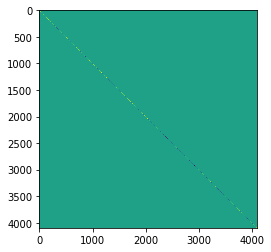

In [6]:
# we can access the basis states and the number of states in the 
# hamiltonian using ham.states and ham.nstates attributes:
states, nstates = ham.states, ham.nstates
# we can make sure that all the states were actually considered:
print(nstates)
# display the hamiltonian matrix - accessing the matrix can be done
# using the .mat attribute

plt.imshow(np.real(ham.mat.todense()))


Please wait, building the Hamiltonian ...
Building the Hamiltonian finished!
924


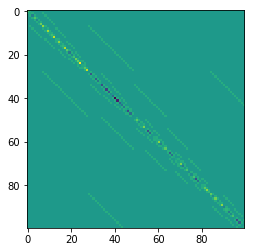

In [7]:
# now construct a hamiltonian in the Sz=0 total spin sector

ham = sp1.hamiltonian(L, static_list, [], Nu=int(L/2.))
print(ham.nstates)
plt.imshow(np.real(ham.mat[:100,:100].todense()))

### Diagonalizing the hamiltonian

In [8]:
# obtaining only the eigvals:

eigvals1 = ham.eigvals()
# obtaining the eigenvectors as well
eigvals2, eigvecs2 = ham.eigsystem()

First ten eigenvalues
[-5.89381843 -5.74278916 -5.4664338  -5.19306317 -4.92232587 -4.83229415
 -4.80571153 -4.74965194 -4.69317547 -4.53743831]
Spectral extrema:
-5.8938184254666215 4.555779635299792


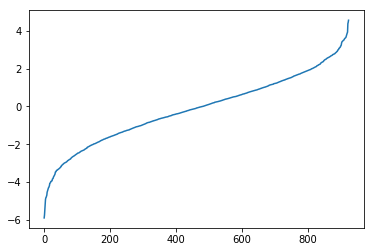

In [9]:
# plotting the spectrum
plt.plot(eigvals1)

print('First ten eigenvalues')
print(eigvals1[:10])
print('Spectral extrema:')
print(eigvals1[0], eigvals1[-1])

## The fermionic case

Let us now redo the calculation for the fermionic case. In this case, the allowed
operator strings are:

* ```['+', '-', 'I', 'n']```

their meaning is:

* ```{'+': c+, '-': c-, 'I': id2, 'n': cn}```

In [39]:
# define the hamiltonian here.
L=12

J_pm = [[J * 0.5 , i, (i + 1)%L] for i in range(L)] # the %L part ensures PBC


hop_left = ['+-', J_pm]

# since we are now dealing with the fermions, we need to take care of the
# normal ordering. The case right hopping is now a bit different than
# in the spin case -> we leave the operator description string unchanged
# and modify the  coupling list instead to properly account for the reversed
# hopping direction.

# right-flipping:
J_mp = [[J * 0.5 , i, (i - 1)%L] for i in range(L)]
hop_right = ['+-', J_mp] #couplings remain the same, only the operator order changes

# interaction:
J_nn = [[J*Delta, i, (i+1)%L] for i in range(L)]
inter_fer = ['nn', J_nn]

#random field

fields = np.array([W * np.cos(2*np.pi*gldn*i) for i in range(1, L+1)])
J_n = [[fields[i], i] for i in range(L)]
rnd_fer = ['n', J_n]

# we can now put together the static_list -> just a list of hamiltonian term
# definitions

static_fer_1 = [hop_left, hop_right, inter_fer, rnd_fer]

In [40]:
ham_fer_1 = fe1.hamiltonian(L, static_fer_1, Nu= int(L/2.))

Please wait, building the Hamiltonian ...
Building the Hamiltonian finished!


In [41]:

eigvals_fer_1 = ham_fer_1.eigvals()

In [42]:
print('First ten eigenvalues')
print(eigvals_fer_1[:10])
print('Spectral extrema:')
print(eigvals_fer_1[0], eigvals_fer_1[-1])

First ten eigenvalues
[-5.87955467 -5.76693489 -5.45855886 -5.19224725 -4.86766257 -4.85415088
 -4.83538082 -4.76572031 -4.67754415 -4.54223033]
Spectral extrema:
-5.879554667435218 4.535185943280719


## Fermionic case with included second-nearest neighbour terms

In [43]:
# we now add the second nearest neighbour terms to the mix
L=12
J_pm_2 = [[J * 0.5 , i, (i + 2)%L] for i in range(L)] # the %L part ensures PBC


hop_left_2 = ['+-', J_pm_2]

J_mp_2 = [[J * 0.5 , i, (i - 2)%L] for i in range(L)]
hop_right_2 = ['+-', J_mp_2] #couplings remain the same, only the operator order changes

J_nn_2 = [[J*Delta, i, (i+2)%L] for i in range(L)]
inter_fer_2 = ['nn', J_nn]
static_fer_2 = static_fer_1 + [hop_left_2, hop_right_2, inter_fer_2]

ham_fer_2 = fe1.hamiltonian(L, static_fer_2, Nu = int(L/2.))

Please wait, building the Hamiltonian ...
Building the Hamiltonian finished!


In [44]:
eigvals_fer_2 = ham_fer_2.eigvals()

First ten eigenvalues
[-7.164116   -6.94311567 -6.759775   -6.46211964 -6.42938426 -6.40261063
 -6.16827363 -6.12010324 -5.97998765 -5.91946862]
Spectral extrema:
-7.164115999319101 5.590659660264921


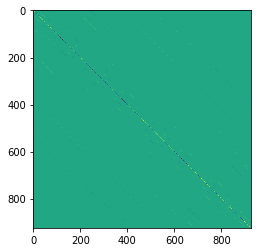

In [45]:
print('First ten eigenvalues')
print(eigvals_fer_2[:10])
print('Spectral extrema:')
print(eigvals_fer_2[0], eigvals_fer_2[-1])

plt.imshow(np.real(ham_fer_2.mat.todense()))

## Noninteracting case, hopping, second-nearest hopping and quasirandom potential

In [1]:
L=12
J=1
W=0.005
J_rnd = np.random.uniform(J*0.001, J, size=L)
fields_free = np.random.uniform(-W, W, size=L)
J_pm = [[J * 0.5 , i, (i + 1)%L] for i in range(L)] # the %L part ensures PBC

hop_left_free = ['+-', J_pm]

J_mp = [[J * 0.5 , i, (i - 1)%L] for i in range(L)]
hop_right_free = ['+-', J_mp] #couplings remain the same, only the operator order changes
#rnd_free = ['n', [[fields_free[i], i] for i in range(L)]]
diag = ['n', [[1., i] for i in range(L)]]
static_free_2 = [hop_right_free, hop_left_free]
ham_free_2 = fr1.hamiltonian(L, static_free_2)

NameError: name 'np' is not defined

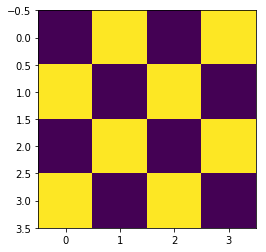

In [47]:
plt.imshow(np.real(ham_free_2.mat).todense())

In [48]:
eigvals_free = ham_free_2.eigvals()